<a href="https://colab.research.google.com/github/Batwan01/2024-Challenge/blob/main/history/24-9-10/MLP5%2BPReLU_normalize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import numpy as np
import random
import pandas as pd
import torch.nn.init as init

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
from google.colab import drive

drive.mount('/content/drive')

# 재현 가능성을 위한 시드 고정
RANDOM_SEED = 18
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Mounted at /content/drive


In [2]:
# 데이터 경로 설정
train_csv_path = "/content/drive/MyDrive/Colab Notebooks/contest/samsung/train.csv"
test_csv_path = "/content/drive/MyDrive/Colab Notebooks/contest/samsung/test.csv"
submission_csv_path = '/content/drive/MyDrive/Colab Notebooks/contest/samsung/sample_submission.csv'

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 데이터 로드 및 병합
train_data = pd.read_csv(train_csv_path)
test = pd.read_csv(test_csv_path)

# x값들을 StandardScaler로 정규화 (ID와 y 제외)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(train_data.drop(['ID', 'y'], axis=1))
X_test_scaled = scaler_X.transform(test)

# y 값을 -0.5 ~ 0.5로 변환
def scale_y(y, min_val=0, max_val=100, new_min=-0.5, new_max=0.5):
    return ((y - min_val) / (max_val - min_val)) * (new_max - new_min) + new_min

train_data_scaled_y = scale_y(train_data['y'])

# DataFrame으로 변환하고 ID와 정규화된 y 값 추가
train_data_scaled = pd.DataFrame(X_train_scaled, columns=train_data.drop(['ID', 'y'], axis=1).columns)
train_data_scaled['ID'] = train_data['ID']
train_data_scaled['y'] = train_data_scaled_y

# 최종 결과 출력
print(train_data_scaled)
print(X_test_scaled)
print("X_test shape:", X_test_scaled.shape)
# print(train_data_scaled['y'])


            x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
0     -1.040745  0.781436  1.242965  1.189315  0.302208 -0.309692 -1.176768   
1     -0.579509 -0.864385 -1.563671 -0.456604 -0.244873  0.444601  0.996471   
2      0.364821 -0.794618 -0.416524  0.100928  0.503561 -0.620301  0.623247   
3      1.033044 -0.818710 -0.471347 -1.189701  0.029542 -0.273565  0.964332   
4     -0.612608  0.229983  1.099601  1.463693  0.333941 -0.373120 -1.146305   
...         ...       ...       ...       ...       ...       ...       ...   
40113  0.593634  0.136997  1.124311  1.136037  0.467738 -0.439685 -0.896794   
40114  1.420847 -0.243945  0.670815  0.687664  0.685335 -0.939960 -0.596119   
40115  0.925301  0.199214  1.154292  0.475335  0.731695 -0.736189 -0.652884   
40116 -1.340591  2.073658  0.704198  0.811714 -0.917495  1.334112 -0.711135   
40117  1.062838 -0.564771 -0.804118 -0.439469  0.199096 -0.026936  0.834894   

            x_7       x_8       x_9      x_10      

In [24]:
# 잔차 연결
class ResidualMLP(nn.Module):
    def __init__(self, input_size=11, hidden_sizes=[11, 11, 11, 11, 11], output_size=1):
        super(ResidualMLP, self).__init__()

        # 6개의 MLP 레이어 정의
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.prelu1 = nn.PReLU()

        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.prelu2 = nn.PReLU()

        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.prelu3 = nn.PReLU()

        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.prelu4 = nn.PReLU()

        self.fc5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
        self.prelu5 = nn.PReLU()

        self.fc6 = nn.Linear(hidden_sizes[4], output_size)
        self.prelu6 = nn.PReLU()


    def forward(self, x):
        # 첫 번째 MLP 레이어
        out = self.prelu1(self.fc1(x))

        # 첫 번째 Residual 연결 (fc1 -> fc2 -> fc3)
        out = self.prelu2(self.fc2(out))
        out = self.prelu3(self.fc3(out))
        out += x
        # 두 번째 Residual 연결 (fc3 -> fc4 -> fc5)
        out = self.prelu4(self.fc4(out))
        out = self.prelu5(self.fc5(out))

        # 최종 출력 레이어 (fc6) 및 PReLU 적용
        out = self.prelu6(self.fc6(out))  # 최종 레이어에도 PReLU 적용

        return out

In [28]:
# 훈련 데이터를 훈련 + 검증 데이터로 나누고 train_dataset, val_dataset 을 반환하는 함수:

X = torch.tensor(train_data_scaled.drop(['ID','y'],axis=1).values, dtype=torch.float32)
y = torch.tensor(train_data_scaled['y'].values, dtype = torch.float32).view(-1,1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

In [29]:
# model = MLP5Hidden()
model = ResidualMLP()
# model = ResidualMLP7()

model.cuda()
criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)


generator = torch.Generator()
generator.manual_seed(RANDOM_SEED)

def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn = worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, worker_init_fn = worker_init_fn)

train_losses = []
val_losses = []

for epoch in range(70):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)


    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/300, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1/300, Train Loss: 0.0025, Validation Loss: 0.0004
Epoch 2/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 3/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 4/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 5/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 6/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 7/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 8/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 9/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 10/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 11/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 12/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 13/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 14/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 15/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 16/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 17/300, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 18/300, Train Los

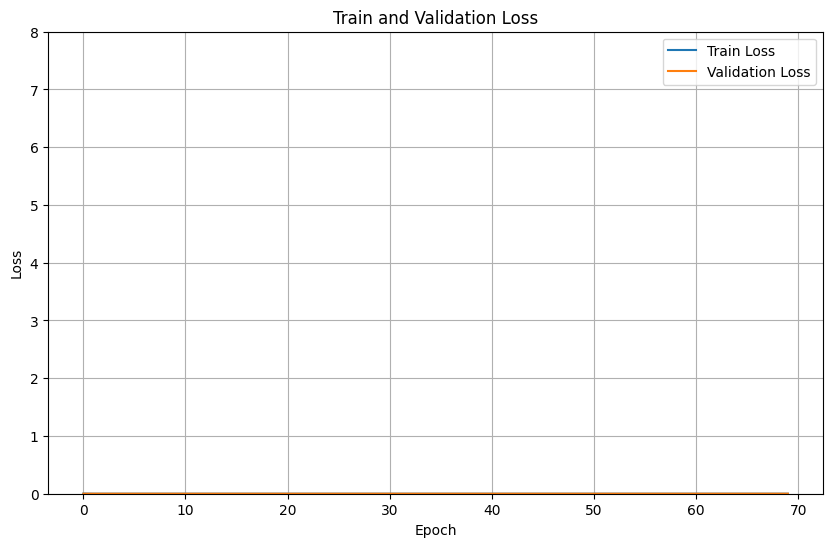

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.ylim(0, 8)
plt.legend()
# plt.savefig(f'Residual_MLP5_threshold10_yweight_epoch100.csv')
plt.grid(True)
plt.show()

In [43]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model.eval()
test_pred = []
with torch.no_grad():
    for batch in test_loader:
        batch_X = batch[0].cuda()
        outputs = model(batch_X)
        test_pred.extend(outputs.cpu().numpy())  # 예측값을 CPU로 이동하여 리스트에 추가

test_pred = np.array(test_pred).flatten()
# y값 역변환 함수 (-0.5 ~ 0.5 → 0 ~ 100)
def inverse_scale_y(y_scaled, min_val=0, max_val=100, new_min=-0.5, new_max=0.5):
    return ((y_scaled - new_min) / (new_max - new_min)) * (max_val - min_val) + min_val

# 예측값을 원래 범위로 변환
# test_pred_original = inverse_scale_y(test_pred)

submission_df = pd.read_csv(submission_csv_path)
submission_df['y'] = test_pred  # 예측 결과를 y 컬럼에 추가
print(submission_df['y'])
# 지정된 경로에 CSV 파일로 저장
submission_df.to_csv("/content/drive/MyDrive/Colab Notebooks/contest/samsung/results/MLP_Residual_normalize.csv", index=False)

0       0.354424
1       0.357741
2       0.346287
3       0.344673
4       0.356921
          ...   
4981    0.354689
4982    0.344627
4983    0.356888
4984    0.357226
4985    0.356694
Name: y, Length: 4986, dtype: float32


In [44]:
submission_df.describe()

,y
count,4986.000000
mean,0.353555
std,0.004845
min,0.341904
25%,0.350800
50%,0.356098
75%,0.357051
max,0.358555


In [45]:
def find_non_matching_ids(file1, file2):
    # 두 개의 CSV 파일을 읽어옴
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # y 값 기준으로 내림차순 정렬
    df1_sorted = df1.sort_values(by='y', ascending=False)
    df2_sorted = df2.sort_values(by='y', ascending=False)

    # file1의 상위 10% 항목 계산
    top_10_percent_count = int(len(df1_sorted) * 0.1)
    top_10_percent_ids_df1 = set(df1_sorted.head(top_10_percent_count)['ID'])

    # file2의 상위 10% ID 추출
    top_10_percent_ids_df2 = set(df2_sorted.head(top_10_percent_count)['ID'])

    # file1의 상위 10% 중 file2의 상위 10%에 없는 ID 계산
    non_matching_ids = top_10_percent_ids_df1 - top_10_percent_ids_df2
    num_non_matching = len(non_matching_ids)

    # 결과 출력
    print(f"file1의 상위 10% 항목 개수: {top_10_percent_count}")
    print(f"file1의 상위 10% 중 file2에 없는 항목 개수: {num_non_matching}")
    print(f"file1의 상위 10% 중 file2에 없는 항목 ID: {non_matching_ids}")

    return top_10_percent_count, num_non_matching, list(non_matching_ids)

# 사용 예시
file1 ='/content/drive/MyDrive/Colab Notebooks/contest/samsung/MLP5_PReLU(0.752).csv' # best 성능 파일
file2 = '/content/drive/MyDrive/Colab Notebooks/contest/samsung/MLP_Residual_Connection_18.csv'
file3 = '/content/drive/MyDrive/Colab Notebooks/contest/samsung/results/MLP_Residual_normalize.csv' # 측정하고자 하는 파일
top_10_percent_count, num_non_matching, non_matching_ids = find_non_matching_ids(file1, file3)
top_10_percent_count, num_non_matching, non_matching_ids = find_non_matching_ids(file2, file3)

file1의 상위 10% 항목 개수: 498
file1의 상위 10% 중 file2에 없는 항목 개수: 498
file1의 상위 10% 중 file2에 없는 항목 ID: {'TEST_4787', 'TEST_2714', 'TEST_4508', 'TEST_4033', 'TEST_2345', 'TEST_3593', 'TEST_1831', 'TEST_4697', 'TEST_4881', 'TEST_4705', 'TEST_0799', 'TEST_3811', 'TEST_2103', 'TEST_1224', 'TEST_2947', 'TEST_3672', 'TEST_4069', 'TEST_3094', 'TEST_0809', 'TEST_2684', 'TEST_4070', 'TEST_4300', 'TEST_3511', 'TEST_3696', 'TEST_1841', 'TEST_3889', 'TEST_1002', 'TEST_1946', 'TEST_3349', 'TEST_3532', 'TEST_3319', 'TEST_2679', 'TEST_3789', 'TEST_4214', 'TEST_1510', 'TEST_4928', 'TEST_3502', 'TEST_2275', 'TEST_2429', 'TEST_1755', 'TEST_3455', 'TEST_0978', 'TEST_3309', 'TEST_0823', 'TEST_1545', 'TEST_0830', 'TEST_4094', 'TEST_4674', 'TEST_1009', 'TEST_0538', 'TEST_0347', 'TEST_2235', 'TEST_1812', 'TEST_2763', 'TEST_1661', 'TEST_3838', 'TEST_4247', 'TEST_3693', 'TEST_3830', 'TEST_2658', 'TEST_0203', 'TEST_1680', 'TEST_3213', 'TEST_0886', 'TEST_2173', 'TEST_1495', 'TEST_2561', 'TEST_0392', 'TEST_2467', 'TEST_1